<a href="https://colab.research.google.com/github/Silviatulli/HIRL-education/blob/main/Learning_from_Feedback_Student_Version_Tetris_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- title: Learning from Human Feedback
- summary: step by step tutorial about TAMER
- authors: Silvia TULLI, Mark DE BRUIJN, Márton Bodó
- feedback and revision: Kim BARAKA, Mohamed CHETOUANI, Muhan HOU
- teaching assistant: Márton Bodó, Fabiano Busca
- date: 2026-February-March

This notebook contains an excerpt from the **Human-Interactive Robot Learning (HIRL)** educational module.\
For more information check out [our website](https://sites.google.com/view/hirl-education?usp=sharing).


The practical can be done alone or with a colleague. Please add below your information.

Student(s):\
(1) NAME___________________ SURNAME___________________ ID___________________ Course___________________\
(2) NAME___________________ SURNAME___________________ ID___________________ Course___________________



# **Goals**
* Familiarize with [Gymnasium](https://gymnasium.farama.org/) environments.
* Apply Learning from Human Feedback techniques to simple tasks.
* Implement TAMER algorithm and a more advanced Learning from Human Feedback algorithm.
* Experiment with parameters such as the number of feedback and their importance to analyze their impact on performance.

# **Prerequisites**

* Mathematics for machine learning: linear algebra, calculus, probability and statitics
* Python programming for data science
* Familiarity with the lecture on interactive robot learning, in particular read the chapter [Interactive Robot Learning](https://hal.science/hal-04060804/file/ACAI2021_chetouani_author-version.pdf)

To better understand the TAMER algorithm, it is necessary to take a step back and review the basics of Reinforcement Learning. A comprehensive reference on Reinforcement Learning is [Barto & Sutton (2018)](https://drive.google.com/file/d/14Ffi1SsuqoFEW87zqX3AE2oeMdQ5SGDZ/view?usp=sharing).



# **Training an Agent Manually via Evaluative Reinforcement**

When demonstrations are challenging for humans to provide, evaluative feedback—evaluating the quality of an action in a given state—can be more intuitive. The TAMER (Training an Agent Manually via Evaluative Reinforcement) algorithm merges elements of imitation learning and evaluative reinforcement learning, addressing the challenges of providing demonstrations. There are several versions of the TAMER algorithm. The **initial version relies solely on rewards from a human trainer**, who receives information about the current state, typically through a visual representation. In subsequent versions, the agent also learns autonomously, **incorporating both the trainer's feedback and environmental rewards by integrating with an existing reinforcement learning** (RL) algorithm. In this assingment, **you will implement a simplified subsequent version of TAMER (i.e., TAMER + RL) based on [this paper](https://bradknox.net/public/papers/aamas12-knox.pdf)**.

TAMER differs from traditional imitation learning in that it does not require a fully labeled dataset of expert demonstrations. Instead, it leverages ongoing feedback from a human during the learning process.

The core steps of the TAMER algorithm are as follows:
1. Initialize the agent's policy.
2. Interact with the environment using this policy.
3. Collect human feedback on the agent's actions.
4. Update the agent's policy using the feedback.
5. Repeat steps 2-4 until the agent's performance improves.


# **Environment Set Up**

To evaluate our algorithms, we will utilize benchmark environments provided by [Gymnasium](https://gymnasium.farama.org). First, we install and import the necessary libraries.

* Gymnasium is an open-source platform maintained by the Farama Foundation (originally developed by OpenAI) to provide a standardized environment for testing and developing reinforcement learning algorithms.

* matplotlib is used to render the environment.

* Scikit-Learn will be used to build our Human Reward Model.

In [1]:
!pip install gymnasium
!pip install matplotlib
!pip install scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Import libraries
import matplotlib.pyplot as plt
import random
import numpy as np
import gymnasium as gym
from typing import Dict, Tuple
from IPython.display import display, update_display, clear_output

# Human Reward Model
from sklearn.tree import DecisionTreeRegressor

## Cart Pole environment

In the foundational work by [Knox and Stone 2008](https://www.cs.utexas.edu/~bradknox/papers/icdl08-knox.pdf), the authors utilized Tetris, from the [RL-library](https://code.google.com/archive/p/rl-library/), to demonstrate the TAMER framework. For this assignment, you will implement a hybrid version (TAMER + RL) based on [this paper](https://bradknox.net/public/papers/aamas12-knox.pdf), applied to the Gymnasium CartPole environment.

In CartPole, a pole is attached to a cart moving along a frictionless track. The goal is to apply forces of +1 or 0 to keep the pole upright. We chose this environment because it allows for intuitive human evaluation: a human can easily judge if a "push" was appropriate given the pole's tilt, whereas momentum-based tasks like Mountain Car are often harder for humans to critique in real-time.

**State and Action Space**

- Observation Space: A continuous 4D vector: `[Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity]`.

**The Model vs. The Agent:**

- The Agent (Q-Learning): To keep the assignment computationally light, the agent's Q-table is simplified by discretizing the Pole Angle and rounding the Angular Velocity.

- The Human Model (Decision Tree): Unlike the Q-table, the Human Reward Model uses the full continuous state space. This allows the agent to generalize the user's feedback more effectively than simple table-based methods.

**Action Space:**

- 0: Push cart to the left

- 1: Push cart to the right

In this interactive setup, the agent will propose an action, and you will provide evaluative feedback. The agent doesn't just store your response; it learns a model of "you" to predict how you would reward its actions in states where you remain silent.

----

## **Question 1 (TAMER + RL)**

In this section, you will implement the first hybrid approach: **Reward Shaping**. According to the TAMER+RL framework, the agent learns from a combined reward signal `R_total` (Note: section 3.1 of the paper of TAMER + RL could be helpful)

Your task is to:

1. Complete the update_q_values method using the SARSA update rule.

2. In the training loop, define total_reward by combining the environment reward and the human model's prediction using the scaling factor β.

#### 1. The human Reward Model

Here we define a Human Reward Model using a `DecisionTreeRegressor` from the `sklearn` library. Instead of using raw human input at every step, the agent trains this model to generalize the human's preferences across the state space.

In [3]:
class HumanModel:
    def __init__(self):
        # We use a Decision Tree to map [state, action] -> predicted_human_reward
        self.model = DecisionTreeRegressor(max_depth=4)
        self.X = []  # State-Action pairs
        self.y = []  # Human feedback labels
        self.fitted = False

    def train(self, state, action, feedback):
        # Store the interaction
        features = np.append(state, action)
        self.X.append(features)
        self.y.append(feedback)

        # Re-fit the model once we have enough samples
        if len(self.X) % 5 == 0 and len(self.X) >= 5:
            self.model.fit(self.X, self.y)
            self.fitted = True

    def predict(self, state, action):
        if not self.fitted:
            return 0.0
        features = np.append(state, action).reshape(1, -1)
        return self.model.predict(features)[0]

#### 2. Environment Initialization

Here, we initialize the environment and define state and action metadata.  
Furthermore, we created a helper function to extract the velocity sign from the cartpole state.

In [4]:
# Initialize Environment
env = gym.make("CartPole-v1", render_mode='rgb_array')

# Define state and action metadata
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
actions_dic = {0: 'Push Left', 1: 'Push Right'}


def extract_velocity(value: float) -> int:
    """Helper to discretize velocity into 0 (Left) or 1 (Right)"""
    return 1 if value > 0 else 0


print(f"Environment Initialized. State Space: {state_size}, Action Space: {action_size}")

Environment Initialized. State Space: 4, Action Space: 2


#### 3. The TAMER Agent

Here we defined the TAMER agent, your **task is to complete the update_q_value method** by using the provided alpha, beta, and gamma hyperparameters. In other words, implement the SARSA update rule.

In [5]:
class TAMERAgent:
    def __init__(self, state_size: int, action_size: int):
        self.state_size = state_size
        self.action_size = action_size
        self.q_values: Dict[Tuple[float, int], Dict[int, float]] = {}

    def act(self, state: np.ndarray, rounding_size: int) -> int:
        state_key = (np.round(state[2], rounding_size), extract_velocity(state[3]))
        
        # Initialize if unseen
        if state_key not in self.q_values:
            self.q_values[state_key] = {a: 0.0 for a in range(self.action_size)}

        # Epsilon-greedy exploration
        if random.random() < 0.1:  
            return random.randint(0, self.action_size - 1)
        else:
            return max(self.q_values[state_key], key=self.q_values[state_key].get)

    def update_q_values(self, state: np.ndarray, action: int, total_reward: float, 
                        next_state: np.ndarray, next_action: int, 
                        alpha: float, gamma: float, rounding_size: int, done: bool) -> None:
        
        state_key = (np.round(state[2], rounding_size), extract_velocity(state[3]))
        next_state_key = (np.round(next_state[2], rounding_size), extract_velocity(next_state[3]))

        # Ensure keys exist
        if state_key not in self.q_values:
            self.q_values[state_key] = {a: 0.0 for a in range(self.action_size)}
        if next_state_key not in self.q_values:
            self.q_values[next_state_key] = {a: 0.0 for a in range(self.action_size)}

        ''' SOLUTION '''
        current_q = self.q_values[state_key][action]
        next_q = self.q_values[next_state_key][next_action]
        
        target = total_reward + (gamma * next_q * (1 - done))
        
        self.q_values[state_key][action] += alpha * (target - current_q)

#### 4. Interactive Training Loop

Now we can train the TAMER agent. 

**Task**: You have to calculate the shaped `total_reward`.

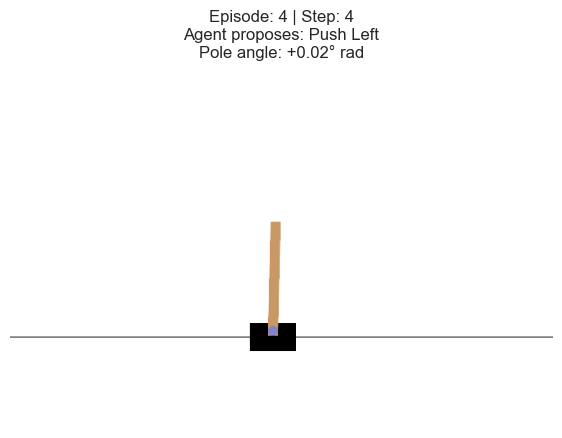

--- HUMAN EVALUATION (Episode 4) ---
Agent proposes: Push Left. Is this good? (1: Yes, 0: No)


KeyboardInterrupt: Interrupted by user

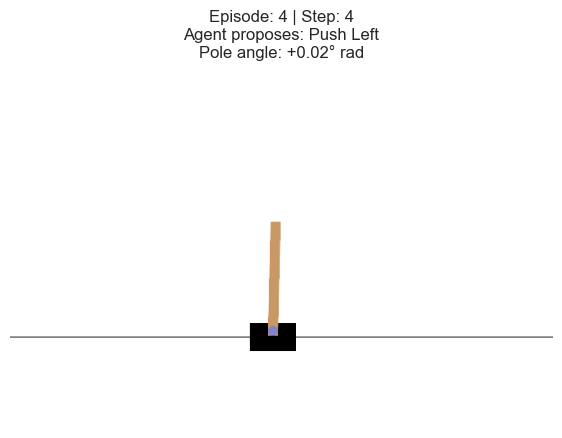

In [6]:
# Hyperparameters
alpha, beta, gamma = 0.1, 5.0, 0.95
num_episodes, timeout_threshold = 20, 500
feedback_budget, rounding_size = 20, 1

# Reset metrics
tamer_agent = TAMERAgent(state_size, action_size)
human_model = HumanModel()
total_reward_per_episode = []

# Plot
fig, ax_sim = plt.subplots(figsize=(7, 5))
display_handle = display(fig, display_id='simulation_window')

for episode in range(num_episodes):
    obs, _ = env.reset()
    state = np.array(obs)
    episode_reward = 0
    feedback_count = 0

    # Initial Action
    action = tamer_agent.act(state, rounding_size)

    for iteration in range(timeout_threshold):

        # Render simulation
        image = env.render()
        ax_sim.clear()
        ax_sim.imshow(image)
        ax_sim.set_title(f"Episode: {episode+1} | Step: {iteration}\n"
                        f"Agent proposes: {actions_dic[action]}\n"
                         f"Pole angle: {state[2]:+.2f}° rad")
        ax_sim.axis('off')
        update_display(fig, display_id='simulation_window')

        # Interective Human Feedback
        if feedback_count < feedback_budget and random.random() > 0.85:
            clear_output(wait=True)
            display(fig, display_id='simulation_window')

            print(f"--- HUMAN EVALUATION (Episode {episode+1}) ---")
            print(f"Agent proposes: {actions_dic[action]}. Is this good? (1: Yes, 0: No)")
            try:
                user_input = input("Feedback, is this good? (1: Yes, 0: No): ").strip()
                if user_input in ['0', '1']:
                    raw_feedback = float(user_input)
                    h_val = 1.0 if raw_feedback == 1.0 else -1.0
                    human_model.train(state, action, h_val)
                    feedback_count += 1
            except EOFError:
                break

            # Reset display
            clear_output(wait=True)
            display(fig, display_id='simulation_window')

        # Env STEP
        # Predict human reward for the CURRENT state/action
        predicted_h = human_model.predict(state, action)

        next_obs, env_reward, terminated, truncated, _ = env.step(action)
        next_state = np.array(next_obs)
        done = terminated or truncated

        # Select next action
        next_action = tamer_agent.act(next_state, rounding_size)

        # Calculate shaped reward & update
        """ SoLUTION """
        total_reward = env_reward + (beta * predicted_h)

        tamer_agent.update_q_values(
            state, action, total_reward, next_state, next_action,
            alpha, gamma, rounding_size, done
        )

        state = next_state
        action = next_action
        episode_reward += env_reward

        if done:
            break

    total_reward_per_episode.append(episode_reward)
    clear_output(wait=True)
    print(f"Episode {episode+1} finished. Total Env Reward: {episode_reward}")

plt.close(fig)

Now we plot how the episodic reward is changed across different episodes to visualize the training performance

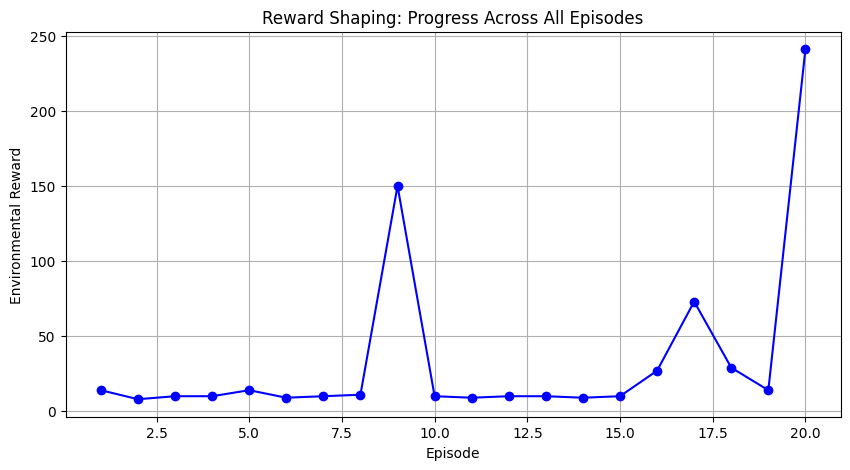

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_episodes + 1), total_reward_per_episode, color='blue', marker='o')
plt.title('Reward Shaping: Progress Across All Episodes')
plt.xlabel('Episode')
plt.ylabel('Environmental Reward')
plt.grid(True)
plt.show()

----

## **Question 2 (TAMER + RL: Q-Augmentation)**

In this section, you will implement the second hybrid approach: Q-Augmentation. Unlike Reward Shaping, which modifies the reward signal R, Q-Augmentation combines the reinforcement learning agent's Q-values with the human's reward model to determine the final policy.

Your task is to:

1. Complete the update_q_values method to implement the Q-Augmentation logic as described in section 3.1 of Knox and Stone (2012).

2. Observe how the agent uses the internal human model to augment its decision-making.

#### 1. The TAMER Agent (Q-Augmentation Version)

**Task:** Complete the update_q_values method. 

Note that in Q-Augmentation, you typically update the standard Q-table using `R_env` but the action selection (policy) is influenced by `Ĥ`.

In [29]:
class TAMERAugmentedAgent:
    def __init__(self, state_size: int, action_size: int):
        self.state_size = state_size
        self.action_size = action_size
        self.q_values = {}

        self.angle_bins = np.linspace(-0.25, 0.25, 12) 
        self.vel_bins = np.linspace(-2.0, 2.0, 10) 

    def get_state_key(self, state):
        """Maps continuous state to a discrete tuple using bins."""
        angle_idx = np.digitize(state[2], self.angle_bins)
        vel_idx = np.digitize(state[3], self.vel_bins)
        return (angle_idx, vel_idx)

    def act(self, state, human_model, beta, epsilon=0.1):
        state_key = self.get_state_key(state)

        # Initialize unseen states
        if state_key not in self.q_values:
            self.q_values[state_key] = {a: 0.0 for a in range(self.action_size)}
            
        # Exploration
        if random.random() < epsilon:
            return random.randint(0, self.action_size - 1)

        # Q-Augmentation: Combine Q-value with Scaled Human Prediction
        augmented_values = {}
        for action in range(self.action_size):
            q_rl = self.q_values[state_key][action]
            
            # Get human prediction
            h_hat = human_model.predict(state, action)
            h_hat = np.clip(h_hat, -1.0, 1.0) # Clip for safety
            
            # Combine
            augmented_values[action] = q_rl + (beta * h_hat)

        return max(augmented_values, key=augmented_values.get)

    def update_q_values(self, state, action, env_reward, next_state, next_action, alpha, gamma, done):
        state_key = self.get_state_key(state)
        next_state_key = self.get_state_key(next_state)

        if state_key not in self.q_values:
            self.q_values[state_key] = {a: 0.0 for a in range(self.action_size)}
        if next_state_key not in self.q_values:
            self.q_values[next_state_key] = {a: 0.0 for a in range(self.action_size)}

        current_q = self.q_values[state_key][action]
        next_q = self.q_values[next_state_key][next_action]

        # SARSA Update Target
        # If done, target is just reward. If not, reward + discounted future.
        if done:
            target = env_reward
        else:
            target = env_reward + gamma * next_q
            
        self.q_values[state_key][action] += alpha * (target - current_q)

#### 2. Interactive Training Loop (Q-Augmentation)

Observe how the agent behaves. Notice that `env_reward` is used for the update, while the `human_model` is used only for the `act` function.

In [30]:
# Hyperparameters
alpha, beta, gamma = 0.1, 5.0, 0.95
num_episodes, timeout_threshold = 20, 500
feedback_budget, rounding_size = 20, 1

# Reset metrics
augmented_agent = TAMERAugmentedAgent(state_size, action_size)
human_model = HumanModel()
total_reward_per_episode_aug = []

# Plot
fig, ax_sim = plt.subplots(figsize=(7, 5))
display_handle = display(fig, display_id='simulation_window_1')

for episode in range(num_episodes):
    obs, _ = env.reset()
    state = np.array(obs)
    episode_reward = 0
    feedback_count = 0

    # Initial Action
    action = tamer_agent.act(state, rounding_size)

    for iteration in range(timeout_threshold):

        # Render simulation
        image = env.render()
        ax_sim.clear()
        ax_sim.imshow(image)
        ax_sim.set_title(f"Episode: {episode+1} | Step: {iteration}\n"
                        f"Agent proposes: {actions_dic[action]}\n"
                         f"Pole angle: {state[2]:+.2f}° rad")
        ax_sim.axis('off')
        update_display(fig, display_id='simulation_window_1')

        # Interective Human Feedback
        if feedback_count < feedback_budget and random.random() > 0.85:
            clear_output(wait=True)
            display(fig, display_id='simulation_window_1')

            print(f"--- HUMAN EVALUATION (Episode {episode+1}) ---")
            print(f"Agent proposes: {actions_dic[action]}. Is this good? (1: Yes, 0: No)")
            try:
                user_input = input("Feedback, is this good? (1: Yes, 0: No): ").strip()
                if user_input in ['0', '1']:
                    raw_feedback = float(user_input)
                    h_val = 1.0 if raw_feedback == 1.0 else -1.0
                    human_model.train(state, action, h_val)
                    feedback_count += 1
            except EOFError:
                break

            # Reset display
            clear_output(wait=True)
            display(fig, display_id='simulation_window_1')

        # Env Step
        next_obs, env_reward, terminated, truncated, _ = env.step(action)
        next_state = np.array(next_obs)
        done = terminated or truncated

        # Update step
        next_action = augmented_agent.act(next_state, human_model, beta, 0.1)

        # Update Q-Values
        augmented_agent.update_q_values(
            state, action, env_reward, next_state, next_action,
            alpha, gamma, done
        )

        state = next_state
        action = next_action
        episode_reward += env_reward
        if done:
            break

    total_reward_per_episode_aug.append(episode_reward)
    clear_output(wait=True)
    print(f"Episode {episode+1} finished. Total Env Reward: {episode_reward}")

plt.close(fig)

Now again, we plot how the episodic reward is changed across different episodes to visualize the training performance

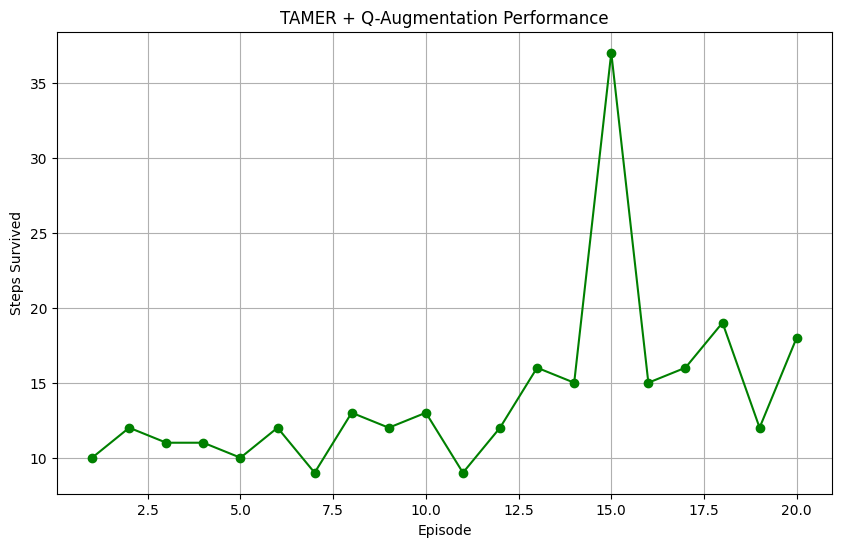

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_episodes + 1), total_reward_per_episode_aug, color='green', marker='o')
plt.title('TAMER + Q-Augmentation Performance')
plt.xlabel('Episode')
plt.ylabel('Steps Survived')
plt.grid(True)
plt.show()

-----

## **Question 3: Comparison and Analysis**

Now that you have implemented both **Reward Shaping** and **Q-Augmentation**, it is time to compare their performance against an **Autonomous Agent** that learns purely from environment rewards.

#### 1. Autonomous Baseline

Run the cell below to train an agent without any human intervention. This agent relies strictly on the environment reward (+1 for every step the pole is balanced).

In [32]:
# Hyperparameters
alpha, gamma = 0.2, 0.95
num_episodes, timeout_threshold = 20, 500
rounding_size = 1

# Reset metrics
autonomous_agent = TAMERAgent(state_size, action_size)
auto_reward_per_episode = []

print("Training Autonomous Agent (No Human Feedback)...")

for episode in range(num_episodes):
    obs, _ = env.reset()
    state = np.array(obs)
    episode_reward = 0

    for iteration in range(timeout_threshold):
        action = autonomous_agent.act(state, rounding_size)
        next_obs, env_reward, terminated, truncated, _ = env.step(action)
        next_state = np.array(next_obs)

        # Update
        next_action = autonomous_agent.act(next_state, rounding_size)
        autonomous_agent.update_q_values(
            state, action, env_reward, next_state, next_action, alpha, gamma, rounding_size, True
        )

        state = next_state
        episode_reward += env_reward
        if terminated or truncated:
            break

    auto_reward_per_episode.append(episode_reward)
    print(f"Autonomous Episode {episode+1} finished. Reward: {episode_reward}")

Training Autonomous Agent (No Human Feedback)...
Autonomous Episode 1 finished. Reward: 9.0
Autonomous Episode 2 finished. Reward: 11.0
Autonomous Episode 3 finished. Reward: 9.0
Autonomous Episode 4 finished. Reward: 10.0
Autonomous Episode 5 finished. Reward: 9.0
Autonomous Episode 6 finished. Reward: 10.0
Autonomous Episode 7 finished. Reward: 9.0
Autonomous Episode 8 finished. Reward: 9.0
Autonomous Episode 9 finished. Reward: 12.0
Autonomous Episode 10 finished. Reward: 10.0
Autonomous Episode 11 finished. Reward: 11.0
Autonomous Episode 12 finished. Reward: 8.0
Autonomous Episode 13 finished. Reward: 9.0
Autonomous Episode 14 finished. Reward: 9.0
Autonomous Episode 15 finished. Reward: 11.0
Autonomous Episode 16 finished. Reward: 8.0
Autonomous Episode 17 finished. Reward: 9.0
Autonomous Episode 18 finished. Reward: 9.0
Autonomous Episode 19 finished. Reward: 10.0
Autonomous Episode 20 finished. Reward: 9.0


#### 2. Performance Visualization

Use the cell below to plot the learning curves of all three methods.

**NOTE:** Ensure you have the lists from the previous tasks ready. If you followed the naming convention, they will be plotted below.

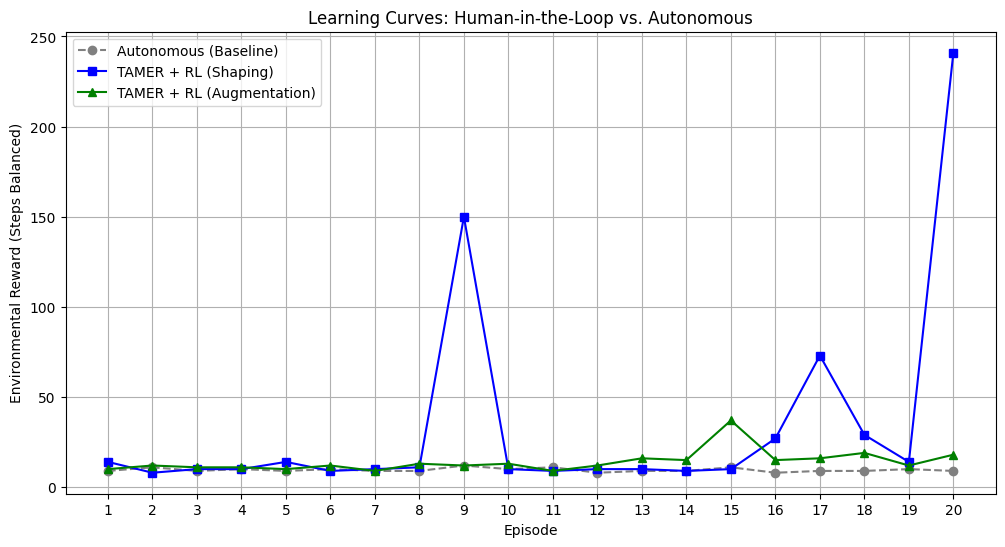

In [33]:
plt.figure(figsize=(12, 6))

# Note: You should have stored results from Q1 and Q2 in separate lists
# For this example, we assume they are named accordingly:
plt.plot(
    range(1, num_episodes + 1),
    auto_reward_per_episode,
    label='Autonomous (Baseline)',
    linestyle='--',
    color='gray',
    marker='o'
)
plt.plot(
    range(1, num_episodes + 1),
    total_reward_per_episode,
    label='TAMER + RL (Shaping)',
    color='blue',
    marker='s'
)
plt.plot(
    range(1, num_episodes + 1),
    total_reward_per_episode_aug,
    label='TAMER + RL (Augmentation)',
    color='green',
    marker='^'
)

plt.title('Learning Curves: Human-in-the-Loop vs. Autonomous')
plt.xlabel('Episode')
plt.ylabel('Environmental Reward (Steps Balanced)')
plt.xticks(range(1, num_episodes + 1))
plt.legend()
plt.grid(True)
plt.show()

## Visualize the Human Model

We used a decision tree do implement the human model so we can easily visualize it. Every node represent a state, with the more important features on top. You will likely see something like theta (the pole angle) > 0 as a first feature since that is generally the main consideration to do before giving feedback

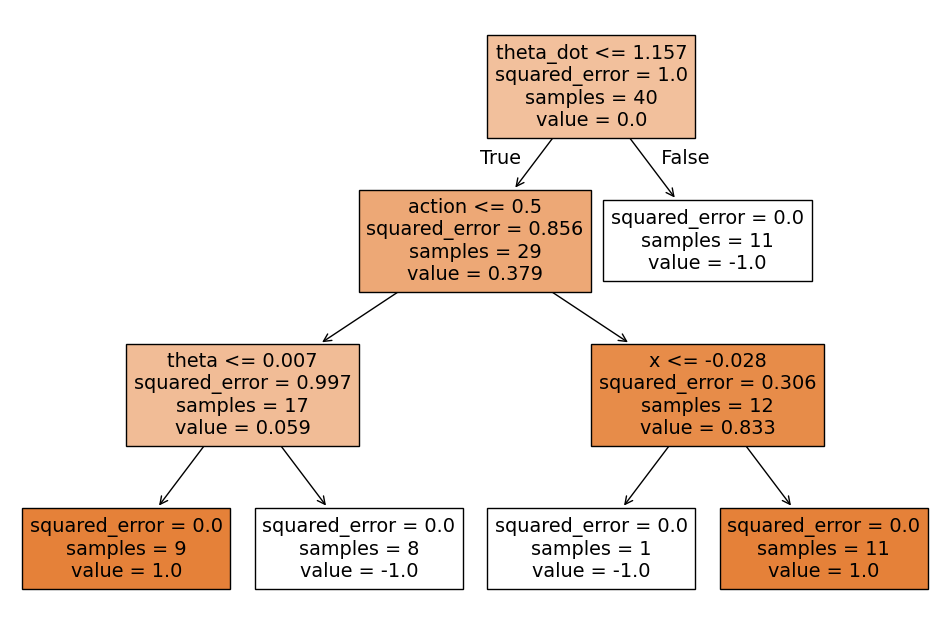

In [34]:
from sklearn.tree import plot_tree
plt.figure(figsize=(12,8))
plot_tree(
    human_model.model,
    feature_names=["x", "x_dot", "theta", "theta_dot", "action"],
    filled=True
)
plt.show()

#### 3. Reflection Questions

**Task:** Answer the questions bellow by editing the markdown cells.

1. Sample Efficiency: Which method reached a stable performance faster? Why does human feedback typically help more in the first few episodes than in later ones?

Your answer...

2. Method Comparison: Compare Reward Shaping vs. Q-Augmentation. In your experiments, did one lead to more "stable" balancing? Refer to the way `Ĥ` is integrated into the math of each method.

Your answer...

3. Human Factors: You provided the feedback yourself. How did your own "latency" (the time it took to type) or "consistency" (giving different rewards for the same state) likely affect the Decision Tree's training?

Your answer...

4. The "Model" Advantage: We used a Decision Tree to model the human. What would happen if we didn't use a model and only updated the agent when you specifically typed a reward? 

Your answer...

-------

## End Of Exercises

We offered a dummy example to illustrate how the algorithm works. However, a greater amount of human feedback is needed to train your agent. For more details and more advanced implementation, we recommend checking the code from the [original GitHub repository](https://github.com/benibienz/TAMER).

# **References**
* Knox, W.B., & Stone, P. (2012). Reinforcement learning from simultaneous human and MDP reward. Adaptive Agents and Multi-Agent Systems. [pdf](https://www.cs.cmu.edu/~jeanoh/16-785/papers/knox-aamas2012-tamer.pdf)
* Warnell, G., Waytowich, N.R., Lawhern, V.J., & Stone, P. (2017). Deep TAMER: Interactive Agent Shaping in High-Dimensional State Spaces. ArXiv, abs/1709.10163.[pdf](https://arxiv.org/pdf/1709.10163.pdf)
* Arakawa, R., Kobayashi, S., Unno, Y., Tsuboi, Y., & Maeda, S. (2018). DQN-TAMER: Human-in-the-Loop Reinforcement Learning with Intractable Feedback. ArXiv, abs/1810.11748. [pdf](https://www.semanticscholar.org/reader/31ed72a18ed8a1008786130af9f1d61761cff4f3)
* Karalus, J., & Lindner, F. (2021). Accelerating the Learning of TAMER with Counterfactual Explanations. 2022 IEEE International Conference on Development and Learning (ICDL), 362-368. [pdf](https://www.semanticscholar.org/reader/243abd03e6fa267219d5afd82f387dddc0db26a3)
* Knox, W.B., & Stone, P. (2009). Interactively shaping agents via human reinforcement: the TAMER framework. International Conference on Knowledge Capture. [pdf](https://www.cs.utah.edu/~dsbrown/readings/tamer.pdf)
